In [102]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision

In [114]:
# load mnist.npz file
mnist = np.load('./assets/mnist.npz')

def to_one_hot(y, n_classes=10):
    return np.eye(n_classes)[y]



In [263]:
raw_x_train = torchvision.datasets.MNIST(root='./assets', train=True, download=True)
raw_x_test = torchvision.datasets.MNIST(root='./assets', train=False, download=True)

In [264]:
type(raw_x_train[2000][0]) , type(raw_x_train[2000][1])

(PIL.Image.Image, int)

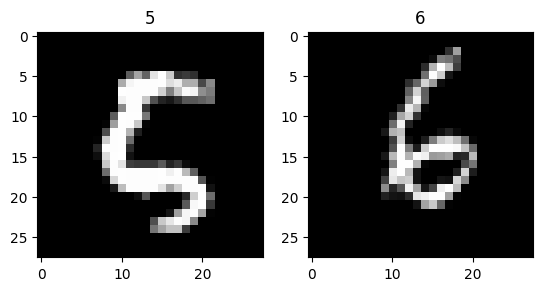

In [266]:
# plot a random image from both the train and test set with the corresponding label next to each other (make them subplots)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(raw_x_train[2000][0], cmap='gray')
ax[0].set_title(raw_x_train[2000][1])
ax[1].imshow(raw_x_test[2000][0], cmap='gray')
ax[1].set_title(raw_x_test[2000][1])

plt.show()


torch.Size([28, 200, 28])


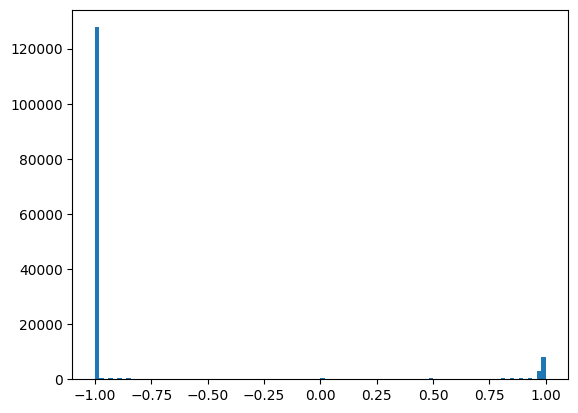

In [190]:
# normalize the data via torchvision.transforms
normalized_mean = 0.5 
normalized_std = 0.5
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((normalized_mean,), (normalized_std,))])
n = 200

dummy = transform(np.array([raw_x_train[i][0] for i in range(n)]))

print(dummy.shape)

#plot a graph of the dummy tensor values distribution
plt.hist(dummy.numpy().flatten(), bins=100)
plt.show()


In [267]:
x_train = np.array([transform(np.array(raw_x_train[i][0])).numpy() for i in range(len(raw_x_train))])
y_train = np.array([raw_x_train[i][1] for i in range(len(raw_x_train))])
x_test = np.array([transform(np.array(raw_x_test[i][0])).numpy() for i in range(len(raw_x_test))])
y_test = np.array([raw_x_test[i][1] for i in range(len(raw_x_test))])

In [207]:
# make the y_train one hot
# y_train = to_one_hot(y_train)
# y_test = to_one_hot(y_test)

In [256]:
# create train_data_loader
train_data_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)),
    batch_size=200,
    shuffle=True
)

In [277]:
for i, data in enumerate(train_data_loader):
    print(data[0].shape, type(data[0]), data[1].shape, type(data[1]))
    break

torch.Size([200, 1, 28, 28]) <class 'torch.Tensor'> torch.Size([200]) <class 'torch.Tensor'>


In [269]:
# create a PyTorch CNN as class which inherits from nn.Module
class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)        
        # self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(in_features=28*28, out_features=32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=32, out_features=10)
        
        
    def forward(self, x):
        # x = self.pool(self.relu(self.conv1(x)))
        # print(x.shape)
        # x = self.pool(self.relu(self.conv2(x)))
        # print(x.shape)
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return x

loss_fn = nn.CrossEntropyLoss()


net = Conv_net() 
for i, data in enumerate(train_data_loader):
    print(data[0].shape, type(data[0]), data[1].shape, type(data[1]))
    y_hat = net(data[0])
    print('y_hat shape:', y_hat.shape)
    print('y shape:', data[1].shape)
    loss = loss_fn(y_hat, data[1].long())
    print('loss:', loss.item())
    break


torch.Size([200, 1, 28, 28]) <class 'torch.Tensor'> torch.Size([200]) <class 'torch.Tensor'>
y_hat shape: torch.Size([200, 10])
y shape: torch.Size([200])
loss: 2.3349735736846924


In [275]:
                
# create a function to train the model
def train_model(x_train, y_train, x_test, y_test, net, loss_fn, optimizer, n_epochs):
    train_loss = []
    test_loss = []
    net.zero_grad()
    for epoch in range(n_epochs):
        for i, data in enumerate(train_data_loader):
            X = data[0]
            y = data[1]
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch {epoch+1}/{n_epochs}, Batch {i+1}/{len(train_data_loader)}, Loss: {loss.item()}')
        train_loss.append(loss_fn(net(torch.tensor(x_train, dtype=torch.float32)), torch.tensor(y_train, dtype=torch.long)).item())
        test_loss.append(loss_fn(net(torch.tensor(x_test, dtype=torch.float32)), torch.tensor(y_test, dtype=torch.long)).item())
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}')
    return train_loss, test_loss


# create a loss function and an optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# train the model
n_epochs = 100
train_loss, test_loss = train_model(x_train, y_train, x_test, y_test, net, loss_fn, optimizer,  n_epochs=n_epochs)



Epoch 1/100, Batch 1/300, Loss: 0.1340610384941101
Epoch 1/100, Batch 101/300, Loss: 0.22228115797042847
Epoch 1/100, Batch 201/300, Loss: 0.1522648185491562
Epoch 1/100, Train Loss: 0.14341843128204346, Test Loss: 0.1585688292980194
Epoch 2/100, Batch 1/300, Loss: 0.1105654165148735
Epoch 2/100, Batch 101/300, Loss: 0.21148867905139923
Epoch 2/100, Batch 201/300, Loss: 0.12667198479175568
Epoch 2/100, Train Loss: 0.13155359029769897, Test Loss: 0.14539310336112976
Epoch 3/100, Batch 1/300, Loss: 0.16000093519687653
Epoch 3/100, Batch 101/300, Loss: 0.17607572674751282
Epoch 3/100, Batch 201/300, Loss: 0.24737757444381714
Epoch 3/100, Train Loss: 0.12806446850299835, Test Loss: 0.14567002654075623
Epoch 4/100, Batch 1/300, Loss: 0.16724899411201477
Epoch 4/100, Batch 101/300, Loss: 0.0766601637005806
Epoch 4/100, Batch 201/300, Loss: 0.16621190309524536
Epoch 4/100, Train Loss: 0.12011081725358963, Test Loss: 0.13899224996566772
Epoch 5/100, Batch 1/300, Loss: 0.14671112596988678
Epoch

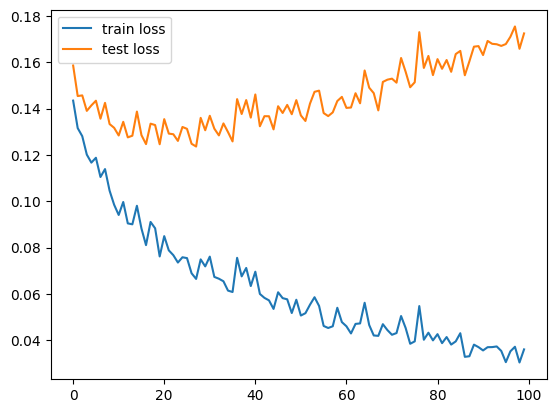

In [276]:
# plot the train and test loss over the epochs
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()


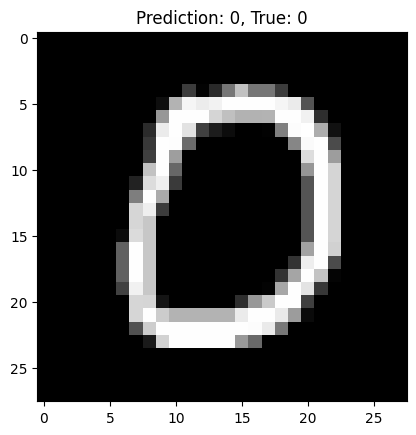

In [274]:
test_index = 10
single_x = x_test[test_index]
single_y = y_test[test_index]
single_y_hat = net(torch.tensor(single_x, dtype=torch.float32))
# plot the single_x and the single_y_hat and the single_y
plt.imshow(single_x[0], cmap='gray')
plt.title(f'Prediction: {single_y_hat.argmax().item()}, True: {single_y}')
plt.show()
